## Data Exploration

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 19.2 MB/s 


In [ ]:
pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 376 kB 63.7 MB/s 
     |████████████████████████████████| 58 kB 7.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=327a311c237e75ef146323a7c974d85ce9b5738e87ad54a893a49103d420fd7d
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=36cc6d3637277f0d5a55639eb0d507ae08ef7da5bef73f590252e40e4d5ce633
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


### Importing Libraries

In [ ]:
import os
import numpy as np
from glob import glob
from tqdm import tqdm
from zipfile import ZipFile as zipfile
import imageio
import cv2
from albumentations import HorizontalFlip, VerticalFlip, Rotate  
import torch
from google.colab.patches import cv2_imshow
import torch.nn as nn
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score, auc, roc_auc_score
from operator import add
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
from torchmetrics import JaccardIndex
from sklearn.model_selection import train_test_split
from torch.utils.data.dataloader import DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
! gdown --id 1d2XiSUZgaM_Zz9dSxAkQ8xMzIW4cROkU
z = zipfile("AV_groundTruth.zip")
z.extractall()
z.close()

train_x = sorted(glob(os.path.join("AV_groundTruth", "training", "images", "*.tif")))
train_y = sorted(glob(os.path.join("AV_groundTruth", "training", "vessel", "*.png")))
print(train_x, '\n', train_y)

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1d2XiSUZgaM_Zz9dSxAkQ8xMzIW4cROkU
To: /content/AV_groundTruth.zip
100% 30.2M/30.2M [00:00<00:00, 148MB/s]
['AV_groundTruth/training/images/21_training.tif', 'AV_groundTruth/training/images/22_training.tif', 'AV_groundTruth/training/images/23_training.tif', 'AV_groundTruth/training/images/24_training.tif', 'AV_groundTruth/training/images/25_training.tif', 'AV_groundTruth/training/images/26_training.tif', 'AV_groundTruth/training/images/27_training.tif', 'AV_groundTruth/training/images/28_training.tif', 'AV_groundTruth/training/images/29_training.tif', 'AV_groundTruth/training/images/30_training.tif', 'AV_groundTruth/training/images/31_training.tif', 'AV_groundTruth/training/images/32_training.tif', 'AV_groundTruth/t

In [ ]:
def load_data(path):
  train_x = sorted(glob(os.path.join(path, "training", "images", "*.tif")))
  train_y = sorted(glob(os.path.join(path, "training", "vessel", "*.png")))

  test_x = sorted(glob(os.path.join(path, "test", "images", "*.tif")))
  test_y = sorted(glob(os.path.join(path, "test", "vessel", "*.png")))

  return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = load_data("AV_groundTruth")

print(f"Train Images: {len(train_x)}, Train Vessels: {len(train_y)}")
print(f"Test Images: {len(test_x)}, Test Vessels: {len(test_y)}")

Train Images: 20, Train Vessels: 20
Test Images: 20, Test Vessels: 20


In [ ]:
# creating directory to save augmented data
def create_dir(path):
  if not os.path.exists(path):
    os.makedirs(path)

create_dir("new_data/train/image/")
create_dir("new_data/train/mask/")
create_dir("new_data/test/image/")
create_dir("new_data/test/mask/")

## Data Augmentation

In [ ]:
import matplotlib.image as mpimg

def augment_data(images, masks, save_path, augment=True, img_size = 224):
  size = (img_size,img_size)

  for idx, (x,y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
    name = x.split("/")[-1].split('.')[0] # extracting the name of the image
    
    # reading image and mask
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    y = cv2.imread(y, 0)
    # try:
    #   y = imageio.mimread(y)[0]
    # except(IOError,ValueError) as e:
    #   pass
    # y = imageio.mimread(y)[0]

    if augment == True:
      aug = HorizontalFlip(p=1.0)
      augmented = aug(image=x, mask = y)
      x1 = augmented["image"]
      y1 = augmented["mask"]

      aug = VerticalFlip(p=1.0)
      augmented = aug(image=x, mask = y)
      x2= augmented["image"]
      y2= augmented["mask"]

      aug = Rotate(limit = 45, p=1.0)
      augmented = aug(image=x, mask = y)
      x3 = augmented["image"]
      y3 = augmented["mask"]

      X = [x,x1,x2,x3]
      Y = [y,y1,y2,y3]

    else:
      X = [x]
      Y = [y]

    index = 0
    for i, m in zip(X,Y):
      i = cv2.resize(i, size)
      m = cv2.resize(m, size) 

      tmp_img = f"{name}_{index}.png"
      tmp_mask = f"{name}_{index}.png"

      image_path = os.path.join(save_path, "image", tmp_img)
      mask_path = os.path.join(save_path, "mask", tmp_mask)

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)
      index +=1

augment_data(train_x, train_y, "new_data/train/", augment=True)
augment_data(test_x, test_y, "new_data/test/", augment=False)

100%|██████████| 20/20 [00:00<00:00, 64.08it/s]


## Functions

In [ ]:
def accuracy_recall(y_true, y_pred):
  """ True value """
  y_true = y_true.detach().cpu().numpy()
  y_true = y_true > 0.5
  y_true = y_true.astype(np.float32)
  y_true = y_true.reshape(-1)

  """ Predictions """
  y_pred = y_pred.detach().cpu().numpy()
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.float32)
  y_pred = y_pred.reshape(-1) 

  acc = accuracy_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  return acc, recall

In [ ]:
def train(model, loader, optimizer, loss_fn, device, dice):
  epoch_loss = 0.0
  iou_score = 0.0
  dice_score = 0.0
  acc = 0.0
  recall = 0.0

  model.train()
  for x,y in loader:
    x = x.to(device, dtype = torch.float32)
    y = y.to(device, dtype = torch.float32)

    optimizer.zero_grad()
    y_pred = model(x)
    loss = loss_fn(y_pred, y)
    DICE = dice(y_pred, y)

    y_true = y
    pred_y = y_pred

    accurate, rec = accuracy_recall(y_true, pred_y)
    acc += accurate
    recall += rec
    y1 = y.int()

    jaccard = JaccardIndex(num_classes=2).to(device)
    iou = jaccard(y_pred, y1)
    iou = iou.float()

    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
    iou_score += iou
    dice_score += DICE.item()

  epoch_loss = epoch_loss/len(loader)
  iou_score = iou_score/ len(loader)
  dice_score = dice_score/len(loader)
  acc = acc/len(loader)
  recall = recall/len(loader)

  return epoch_loss, iou_score, dice_score, acc, recall

In [ ]:
def evaluate(model, loader, loss_fn, device, dice):
  epoch_loss = 0.0
  iou_score = 0.0
  dice_score = 0.0
  acc = 0.0
  recall = 0.0
  f1 = 0.0
  auc = 0.0

  model.eval()
  with torch.no_grad():
    for x,y in loader:
      x = x.to(device, dtype = torch.float32)
      y = y.to(device, dtype = torch.float32)

      y_pred = model(x)
      loss = loss_fn(y_pred, y )
      DICE = dice(y_pred, y)

      y_true = y
      pred_y = y_pred

      accurate, rec = accuracy_recall(y_true, pred_y)
      acc += accurate
      recall += rec

      y_p = y_pred.cpu().numpy() > 0.5
      y_t = y_true.cpu().numpy() > 0.5
      y_t = y_t.astype(np.uint8)
      y_t = y_t.reshape(-1)
      y_p = y_p.astype(np.uint8)
      y_p = y_p.reshape(-1)
      f = f1_score(y_t, y_p)
      auc_roc = roc_auc_score(y_t, y_p )
      f1 += f
      auc += auc_roc

      y1 = y.int()
      jaccard = JaccardIndex(num_classes=2).to(device)
      iou = jaccard(y_pred, y1)
      iou = iou.float()

      epoch_loss += loss.item()
      iou_score += iou
      dice_score += DICE.item()

    # metrics = [smp.utils.metrics.IoU(threshold=0.5)]
    epoch_loss = epoch_loss/len(loader)
    iou_score = iou_score/ len(loader)
    dice_score = dice_score/len(loader)
    acc = acc/len(loader)
    recall = recall/len(loader)
    f1 = f1/len(loader)
    auc = auc/len(loader)

  return epoch_loss, iou_score, dice_score, acc, recall, f1, auc

In [ ]:
def calculate_metrics(y_true, y_pred):
  """ True value """
  y_true = y_true.cpu().numpy()
  y_true = y_true > 0.5
  y_true = y_true.astype(np.uint8)
  y_true = y_true.reshape(-1)

  """ Predictions """
  y_pred = y_pred.cpu().numpy()
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.uint8)
  y_pred = y_pred.reshape(-1) 

  jaccard = jaccard_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)
  recall = recall_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred)
  accuracy = accuracy_score(y_true, y_pred)
  aur_roc = roc_auc_score(y_true, y_pred )

  return [jaccard, f1, recall, precision, accuracy, aur_roc]

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

def test(model, dice):
  metrics_score = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  time_taken =[]
  iou_score = 0.0
  dice_score = 0.0

  for i, (x,y) in tqdm(enumerate(zip(test_x, test_y)), total = len(test_x)):
    # extract name
    name = y.split("/")[-1].split(".")[0]

    """ Reading image """
    image = cv2.imread(x, cv2.IMREAD_COLOR) ## (512, 512, 3)
    ## image = cv2.resize(image, size)
    x = np.transpose(image, (2, 0, 1))      ## (3, 512, 512)
    x = x/255.0
    x = np.expand_dims(x, axis=0)           ## (1, 3, 512, 512)
    x = x.astype(np.float32)
    x = torch.from_numpy(x)
    x = x.to(device)

    """ Reading mask """
    mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    ## mask = cv2.resize(mask, size)
    y = np.expand_dims(mask, axis=0)            ## (1, 512, 512)
    y = y/255.0
    y = np.expand_dims(y, axis=0)               ## (1, 1, 512, 512)
    y = y.astype(np.float32)
    y = torch.from_numpy(y)
    y = y.to(device)

    with torch.no_grad():
      start_time = time.time()
      pred_y = model(x)
      DICE = dice(pred_y, y)
      y1 = y.int()
      jaccard = JaccardIndex(num_classes=2).to(device)
      iou = jaccard(pred_y, y1)
      iou = iou.float()
      pred_y = torch.sigmoid(pred_y)
      total_time = time.time() - start_time
      time_taken.append(total_time)

      score = calculate_metrics(y, pred_y)
      metrics_score = list(map(add, metrics_score, score))
      pred_y = pred_y[0].cpu().numpy()  # (1,512, 512)
      pred_y = np.squeeze(pred_y, axis=0) # (512, 512)
      pred_y = pred_y > 0.5
      pred_y = np.array(pred_y, dtype=np.uint8)

      iou_score += iou
      dice_score += DICE.item()

    # """ Saving Masks """
    # ori_mask = mask_parse(mask)
    # pred_y = mask_parse(pred_y)
    # line = np.ones((size[1], 10, 3)) * 128

    # cat_images = np.concatenate(
    #     [image, line, ori_mask, line, pred_y * 255], axis=1
    # )
    # cv2.imwrite(f"results/{name}.png", cat_images)

  jaccard = metrics_score[0]/len(test_x)
  f1 = metrics_score[1]/len(test_x)
  recall = metrics_score[2]/len(test_x)
  precision = metrics_score[3]/len(test_x)
  acc = metrics_score[4]/len(test_x)
  iou_score = iou_score/len(test_x)
  dice_score = dice_score/len(test_x)
  auc_score = metrics_score[5]/len(test_x)
  print(f"Jaccard: {jaccard:1.4f} - F1-Score: {f1:1.4f} - Recall: {recall:1.4f}  - iou_score: {iou_score:1.4f} -  dice: {dice_score:1.4f} - Precision: {precision:1.4f} - Acc: {acc:1.4f} AUC-ROC: {auc_score:1.4f}")


In [ ]:
# Plot validation training curves
def plot_loss(val_loss, train_loss):
    # loss = history.history["loss"]
    # val_loss = history.history["val_loss"]
    # accuracy = history.history["accuracy"]
    # val_accuracy = history.history["val_accuracy"]
    # epochs = range(len(history.history["loss"])) # how many epochs did we run

    # Plot loss
    plt.plot(train_loss, label="Training loss")
    plt.plot(val_loss, label="val_loss")
    plt.ylim(0,1.4)
    plt.title("loss")
    plt.xlabel("epochs")
    plt.legend()

## Utility

In [ ]:
import time
import random

""" Seeding the randomness. """
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

""" Create a directory. """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Calculate the time taken """
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

## Data Pipeline

In [ ]:
from torch.utils.data import Dataset

class DriveDataset(Dataset):
  def __init__(self, images_path, mask_path):

    self.images_path = images_path
    self.mask_path = mask_path
    self.n_samples = len(images_path)

  def __getitem__(self, index):
    """ Read image """
    image = cv2.imread(self.images_path[index], cv2.IMREAD_COLOR)
    image = image/255.0 # (512, 512, 3)
    image = np.transpose(image, (2,0,1)) # (3, 512, 512)
    image = image.astype(np.float32)
    image = torch.from_numpy(image)

    """ Read mask """
    mask = cv2.imread(self.mask_path[index], cv2.IMREAD_GRAYSCALE)
    mask = mask/255.0   ## (512, 512)
    mask = np.expand_dims(mask, axis=0) ## (1, 512, 512)
    mask = mask.astype(np.float32)
    mask = torch.from_numpy(mask) 

    return image, mask

  def __len__(self):
    return self.n_samples

## Datasets

In [ ]:
from torch.utils.data.dataloader import DataLoader

# seed
seeding(42)

# create directories
create_dir("files")

# loading data
train_x = sorted(glob("new_data/train/image/*"))
train_y = sorted(glob("new_data/train/mask/*"))

valid_x = sorted(glob("new_data/test/image/*"))
valid_y = sorted(glob("new_data/test/mask/*"))

""" Hyperparameters """
H = 512
W = 512
size = (H,W)
batch_size = 2
num_epochs = 100
lr = 1e-4

""" Dataset and DataLoader """
train_dataset = DriveDataset(train_x, train_y)
valid_dataset = DriveDataset(valid_x, valid_y)

train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size, shuffle=False, num_workers=2)

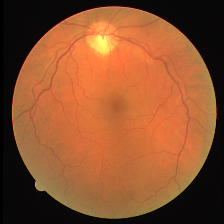

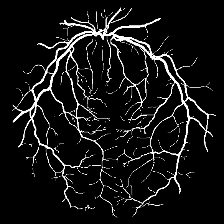

In [ ]:
test_x = sorted(glob("new_data/test/image/*"))
test_y = sorted(glob("new_data/test/mask/*"))
batch_size = 2

test_dataset = DriveDataset(test_x, test_y)
test_dl = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle=True, num_workers=2)

for i,l in test_dl:
  i = i.to(device)
  # pred_y = pred_y[0].detach().cpu().numpy()        ## (1, 512, 512)
  # pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
  # pred_y = pred_y > 0.5
  # pred_y = np.array(pred_y, dtype=np.uint8)
  # pred_y = mask_parse(pred_y)
  # print(pred_y.shape)
  x = i[0].detach().cpu().numpy()
  y = l[0].detach().cpu().numpy()
  x = np.transpose(x, (2,1, 0))
  y = np.transpose(y,(2,1,0))
  # x = np.squeeze(x, axis=0)
  # print(y.shape) 
  # ground = l[0].detach().cpu().numpy()
  # ground = np.transpose(ground, (2,1,0))
  # print(ground.shape)
  # x = mask_parse(x)
  cv2_imshow(x*255)
  cv2_imshow(y*255)
  # cv2_imshow(ground*255)
  break

## Loss Functions

In [ ]:
import torch.nn.functional as F

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

class DiceScore(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceScore, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = torch.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return dice

## Base Blocks

In [ ]:
class conv_block(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(out_c)

    self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(out_c)

    self.relu = nn.ReLU()

  def forward(self, inputs):
    x = self.conv1(inputs)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    
    return x

class encoder(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.conv = conv_block(in_c, out_c)
    self.pool = nn.MaxPool2d((2,2))

  def forward(self, inputs):
    x = self.conv(inputs)
    p = self.pool(x)

    return x, p

class decoder(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.conv = conv_block(out_c + out_c, out_c)

  def forward(self, inputs, skip):
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

## Loading Transfer Learning Models

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class Model_Res50(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(
    encoder_name = "resnet50",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1,
    activation = 'sigmoid',)

  def forward(self, image):
    mask = self.model(image)
    return mask

class Model_Res34(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(
    encoder_name = "resnet34",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1,
    activation = 'sigmoid',)

  def forward(self, image):
    mask = self.model(image)
    return mask

class Model_MobileV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(
    encoder_name = "mobilenet_v2",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1,
    activation = 'sigmoid',)

  def forward(self, image):
    mask = self.model(image)
    return mask

class Model_EfficientB0(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = smp.Unet(
    encoder_name = "efficientnet-b0",
    encoder_weights = "imagenet",
    in_channels = 3,
    classes = 1,
    activation = 'sigmoid',)

  def forward(self, image):
    mask = self.model(image)
    return mask

In [ ]:
model_res50 = Model_Res50()
model_res34 = Model_Res34()
model_mobv2 = Model_MobileV2()
model_res50.load_state_dict(torch.load("/content/gdrive/MyDrive/Res50.pth"))
# model_res34.load_state_dict(torch.load("/content/gdrive/MyDrive/Copy of Res34.pth",map_location=torch.device('cpu')))
# model_res34.load_state_dict(torch.load("/content/gdrive/MyDrive/Res34.pth",map_location=torch.device('cpu')))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:
model_res50 = model_res50.to(device)
model_res34 = model_res34.to(device)
model_effb0 = Model_EfficientB0()
model_effb0 = model_effb0.to(device)
# model_effb0.load_state_dict(torch.load("/content/gdrive/MyDrive/EfficientB0.pth",map_location=torch.device('cpu')))
# model_mobv2.load_state_dict(torch.load("/content/gdrive/MyDrive/MobielV2.pth"))

In [ ]:
model_mobv2 = model_mobv2.to(device)

In [ ]:
num_epochs=150

## Testing

In [ ]:
def mask_parse(mask):
    mask = np.expand_dims(mask, axis=-1)    ## (512, 512, 1)
    mask = np.concatenate([mask, mask, mask], axis=-1)  ## (512, 512, 3)
    return mask

In [ ]:
for i,l in train_loader:
  i = i.to(device)
  pred_y = model_res50(i)
  # pred_y = pred_y[0].detach().cpu().numpy()        ## (1, 512, 512)
  # # pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
  # # pred_y = pred_y > 0.5
  # # pred_y = np.array(pred_y, dtype=np.uint8)
  # # pred_y = mask_parse(pred_y)
  # # print(pred_y.shape)
  # x = i[0].detach().cpu().numpy()
  # x = np.transpose(x, (2,1, 0))
  # y = np.transpose(pred_y,(2,1,0))
  # # x = np.squeeze(x, axis=0)
  # # print(y.shape) 
  # ground = l[0].detach().cpu().numpy()
  # ground = np.transpose(ground, (2,1,0))
  # # print(ground.shape)
  # # x = mask_parse(x)
  # cv2_imshow(x*255)
  # cv2_imshow(y*255)
  # cv2_imshow(ground*255)
  y_true = l.detach().cpu().numpy()
  y_true = y_true > 0.5
  y_true = y_true.astype(np.float32)
  y_true = y_true.reshape(-1)

  y_pred = pred_y.detach().cpu().numpy()
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.float32)
  y_pred = y_pred.reshape(-1)
  print(f"F1-Score: {f1_score(y_true, y_pred)} AUC-ROC: {roc_auc_score(y_true, y_pred)}")
  

F1-Score: 0.12190288522901575 AUC-ROC: 0.48923896439217074
F1-Score: 0.14614027348919278 AUC-ROC: 0.4948361852653905
F1-Score: 0.14838280903854673 AUC-ROC: 0.49496516408110275
F1-Score: 0.14998792190965587 AUC-ROC: 0.4954220586705226
F1-Score: 0.1710986172314238 AUC-ROC: 0.5014936053344539
F1-Score: 0.16141963877208654 AUC-ROC: 0.49216159827615125
F1-Score: 0.15070405504930035 AUC-ROC: 0.49030871972387347


KeyboardInterrupt: ignored

# Resnet-50

## Model-1

In [ ]:
class Res50Unet(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
  x = torch.randn((2,3,224,224))
  x = x.to(device)
  b = Unet()
  b = b.to(device)
  y = b(x)
  y.shape

In [ ]:
model = Unet()
model.load_state_dict(torch.load('gdrive/MyDrive/Res50_Unet-1_150.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

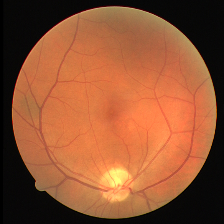

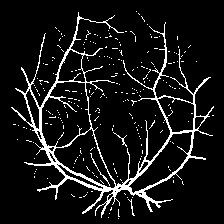

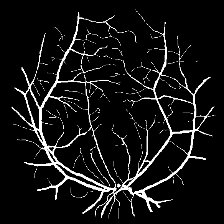

In [ ]:
for i,l in train_loader:
  i = i.to(device)
  pred_y = model(i)
  pred_y = pred_y[0].detach().cpu().numpy()        ## (1, 512, 512)
  # pred_y = np.squeeze(pred_y, axis=0)     ## (512, 512)
  pred_y = pred_y > 0.5
  # pred_y = np.array(pred_y, dtype=np.uint8)
  # pred_y = mask_parse(pred_y)
  # print(pred_y.shape)
  x = i[0].detach().cpu().numpy()
  x = np.transpose(x, (2,1, 0))
  y = np.transpose(pred_y,(2,1,0))
  # x = np.squeeze(x, axis=0)
  # print(y.shape) 
  ground = l[0].detach().cpu().numpy()
  ground = np.transpose(ground, (2,1,0))
  # print(ground.shape)
  # x = mask_parse(x)
  cv2_imshow(x*255)
  cv2_imshow(y*255)
  cv2_imshow(ground*255)
  break

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda')
model_res50_1 = Unet()
model_res50_1 = model_res50_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/Res50_Unet-1_150_max.pth"

optimizer = torch.optim.Adam(model_res50_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res50_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res50_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 14s
	 Train Loss: 1.4865, train_iou: 0.7668, train_dice: 0.1927, train_accuracy: 0.9721, train_recall: 0.8281
	 Val. Loss: 1.4963, val_iou: 0.7483, val_dice: 0.1863, valid_accuracy: 0.9617, valid_recall: 0.7425

Epoch: 02 | Epoch Time: 0m 12s
	 Train Loss: 1.4834, train_iou: 0.7728, train_dice: 0.1931, train_accuracy: 0.9737, train_recall: 0.8270
	 Val. Loss: 1.4949, val_iou: 0.7483, val_dice: 0.1865, valid_accuracy: 0.9617, valid_recall: 0.7425

Epoch: 03 | Epoch Time: 0m 12s
	 Train Loss: 1.4835, train_iou: 0.7727, train_dice: 0.1930, train_accuracy: 0.9736, train_recall: 0.8254
	 Val. Loss: 1.4949, val_iou: 0.7483, val_dice: 0.1865, valid_accuracy: 0.9617, valid_recall: 0.7425

Epoch: 04 | Epoch Time: 0m 13s
	 Train Loss: 1.4833, train_iou: 0.7731, train_dice: 0.1931, train_accuracy: 0.9738, train_recall: 0.8277
	 Val. Loss: 1.4949, val_iou: 0.7483, val_dice: 0.1865, valid_accuracy: 0.9617, valid_recall: 0.7425

Epoch: 05 | Epoch Time: 0m 13s
	 Train Loss:

In [ ]:
torch.save(model_res50_1.state_dict(), "gdrive/MyDrive/Res50_Unet-1.pth")

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validRes50-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainRes50-1.csv")

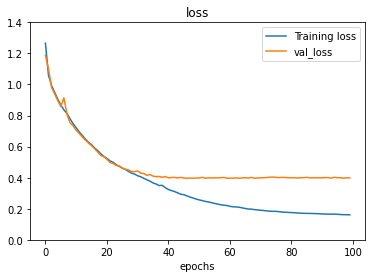

In [ ]:
tf = pd.read_csv("trainRes50-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("validRes50-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-2

In [ ]:
class Res50Unet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
x = torch.randn((2,3,224,224))
x = x.to(device)
b = Unet_2()
b = b.to(device)
y = b(x)
y.shape

torch.Size([2, 1, 224, 224])

### Training

In [ ]:
model_res50_2 = Unet_2()
model_res50_2 = model_res50_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/Res50_Unet-2.pth"

optimizer = torch.optim.Adam(model_res50_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res50_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res50_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 16s
	 Train Loss: 1.2660, train_iou: 0.7074, train_dice: 0.2462, train_accuracy: 0.9506, train_recall: 0.8027
	 Val. Loss: 1.1890, val_iou: 0.5699, val_dice: 0.2086, valid_accuracy: 0.9259, valid_recall: 0.1275

Epoch: 02 | Epoch Time: 0m 17s
	 Train Loss: 1.0588, train_iou: 0.7162, train_dice: 0.3057, train_accuracy: 0.9533, train_recall: 0.7458
	 Val. Loss: 1.0983, val_iou: 0.7256, val_dice: 0.3048, valid_accuracy: 0.9517, valid_recall: 0.6567

Epoch: 03 | Epoch Time: 0m 16s
	 Train Loss: 0.9935, train_iou: 0.7221, train_dice: 0.3318, train_accuracy: 0.9554, train_recall: 0.7470
	 Val. Loss: 0.9803, val_iou: 0.7130, val_dice: 0.3359, valid_accuracy: 0.9523, valid_recall: 0.7419

Epoch: 04 | Epoch Time: 0m 16s
	 Train Loss: 0.9496, train_iou: 0.7234, train_dice: 0.3505, train_accuracy: 0.9561, train_recall: 0.7504
	 Val. Loss: 0.9397, val_iou: 0.7263, val_dice: 0.3550, valid_accuracy: 0.9559, valid_recall: 0.7396

Epoch: 05 | Epoch Time: 0m 16s
	 Train Loss:

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validRes50-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainRes50-2.csv")

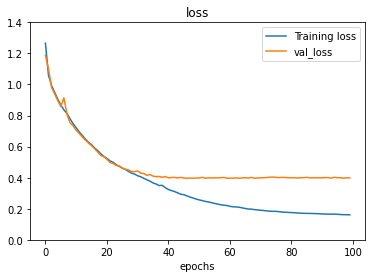

In [ ]:
tf = pd.read_csv("trainRes50-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("validRes50-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-3

In [ ]:
class Res50Unet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
x = torch.randn((2,3,224,224))
x = x.to(device)
b = Unet_3()
b = b.to(device)
y = b(x)
y.shape

torch.Size([2, 1, 224, 224])

### Training

In [ ]:
model_res50_3 = Unet_3()
model_res50_3 = model_res50_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/Res50_Unet-3.pth"

optimizer = torch.optim.Adam(model_res50_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res50_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res50_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 34s
	 Train Loss: 1.2732, train_iou: 0.6849, train_dice: 0.2477, train_accuracy: 0.9264, train_recall: 0.8120
	 Val. Loss: 1.2611, val_iou: 0.6112, val_dice: 0.1971, valid_accuracy: 0.9306, valid_recall: 0.1880

Epoch: 02 | Epoch Time: 0m 30s
	 Train Loss: 1.0355, train_iou: 0.7226, train_dice: 0.3148, train_accuracy: 0.9564, train_recall: 0.7693
	 Val. Loss: 0.9968, val_iou: 0.7461, val_dice: 0.3162, valid_accuracy: 0.9579, valid_recall: 0.6744

Epoch: 03 | Epoch Time: 0m 30s
	 Train Loss: 0.9638, train_iou: 0.7273, train_dice: 0.3446, train_accuracy: 0.9579, train_recall: 0.7681
	 Val. Loss: 0.9374, val_iou: 0.7276, val_dice: 0.3553, valid_accuracy: 0.9576, valid_recall: 0.7609

Epoch: 04 | Epoch Time: 0m 30s
	 Train Loss: 0.9000, train_iou: 0.7325, train_dice: 0.3741, train_accuracy: 0.9597, train_recall: 0.7727
	 Val. Loss: 0.8897, val_iou: 0.7355, val_dice: 0.3760, valid_accuracy: 0.9592, valid_recall: 0.7476

Epoch: 05 | Epoch Time: 0m 31s
	 Train Loss:

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validRes50-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainRes50-3.csv")

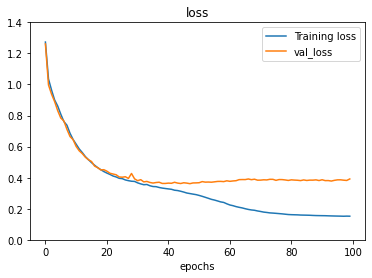

In [ ]:
tf = pd.read_csv("trainRes50-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("validRes50-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet 1

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels_x, in_channels_g, int_channels):
        super(AttentionBlock, self).__init__()
        self.Wx = nn.Sequential(nn.Conv2d(in_channels_x, int_channels, kernel_size = 1),
                                nn.BatchNorm2d(int_channels))
        self.Wg = nn.Sequential(nn.Conv2d(in_channels_g, int_channels, kernel_size = 1),
                                nn.BatchNorm2d(int_channels))
        self.psi = nn.Sequential(nn.Conv2d(int_channels, 1, kernel_size = 1),
                                 nn.BatchNorm2d(1),
                                 nn.Sigmoid())
    
    def forward(self, x, g):
        # apply the Wx to the skip connection
        x1 = self.Wx(x)
        # after applying Wg to the input, upsample to the size of the skip connection
        g1 = nn.functional.interpolate(self.Wg(g), x1.shape[2:], mode = 'bilinear', align_corners = False)
        out = self.psi(nn.ReLU()(x1 + g1))
        out = nn.Sigmoid()(out)
        return out*x


class attention_decoder(nn.Module):
  def __init__(self, in_c, out_c):
    super().__init__()

    self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
    self.attention = AttentionBlock(out_c, in_c, int(out_c / 2))
    self.conv = conv_block(out_c + out_c, out_c)

  def forward(self, inputs, skip):
    x_attention = self.attention(skip, inputs)
    x = self.up(inputs)
    x = torch.cat([x, skip], axis=1)
    x = self.conv(x)
    return x

In [ ]:
class Res50AttentionUnet_1(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = attention_decoder(1024, 512)
    self.d2 = attention_decoder(512, 256)
    self.d3 = attention_decoder(256, 128)
    self.d4 = attention_decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
x = torch.randn((2,3,224,224))
x = x.to(device)
b = AttentionUnet_1()
b = b.to(device)
y = b(x)
y.shape

torch.Size([2, 1, 224, 224])

### Training

In [ ]:
att_model_res50_1 = AttentionUnet_1()
att_model_res50_1 = att_model_res50_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelRes50-1.pth"

optimizer = torch.optim.Adam(att_model_res50_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res50_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res50_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res50_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 14s
	 Train Loss: 1.2192, train_iou: 0.7224, train_dice: 0.2479, train_accuracy: 0.9559, train_recall: 0.7523
	 Val. Loss: 1.1946, val_iou: 0.5775, val_dice: 0.2063, valid_accuracy: 0.9267, valid_recall: 0.1391

Epoch: 02 | Epoch Time: 0m 16s
	 Train Loss: 1.0241, train_iou: 0.7262, train_dice: 0.3146, train_accuracy: 0.9559, train_recall: 0.7351
	 Val. Loss: 0.9675, val_iou: 0.7355, val_dice: 0.3315, valid_accuracy: 0.9561, valid_recall: 0.6895

Epoch: 03 | Epoch Time: 0m 15s
	 Train Loss: 0.9692, train_iou: 0.7268, train_dice: 0.3397, train_accuracy: 0.9566, train_recall: 0.7467
	 Val. Loss: 0.9387, val_iou: 0.7409, val_dice: 0.3461, valid_accuracy: 0.9582, valid_recall: 0.7097

Epoch: 04 | Epoch Time: 0m 14s
	 Train Loss: 0.9157, train_iou: 0.7335, train_dice: 0.3642, train_accuracy: 0.9588, train_recall: 0.7522
	 Val. Loss: 0.9026, val_iou: 0.7301, val_dice: 0.3703, valid_accuracy: 0.9573, valid_recall: 0.7504

Epoch: 05 | Epoch Time: 0m 13s
	 Train Loss:

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes50-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes50-1.csv")

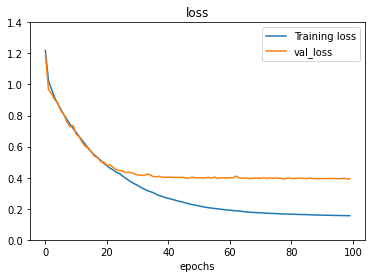

In [ ]:
tf = pd.read_csv("AttentionTrainRes50-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes50-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-2

In [ ]:
class Res50AttentionUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_res50_2 = AttentionUnet_2()
att_model_res50_2 = att_model_res50_2.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelRes50-2.pth"

optimizer = torch.optim.Adam(att_model_res50_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res50_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res50_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res50_2.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 24s
	 Train Loss: 1.2742, train_iou: 0.7334, train_dice: 0.2339, train_accuracy: 0.9585, train_recall: 0.7854
	 Val. Loss: 1.1978, val_iou: 0.6026, val_dice: 0.2060, valid_accuracy: 0.9302, valid_recall: 0.1873

Epoch: 02 | Epoch Time: 0m 16s
	 Train Loss: 1.1003, train_iou: 0.7224, train_dice: 0.2899, train_accuracy: 0.9567, train_recall: 0.7793
	 Val. Loss: 1.1087, val_iou: 0.7218, val_dice: 0.2833, valid_accuracy: 0.9525, valid_recall: 0.7194

Epoch: 03 | Epoch Time: 0m 16s
	 Train Loss: 1.0442, train_iou: 0.7211, train_dice: 0.3125, train_accuracy: 0.9562, train_recall: 0.7722
	 Val. Loss: 1.0221, val_iou: 0.7369, val_dice: 0.3126, valid_accuracy: 0.9573, valid_recall: 0.7145

Epoch: 04 | Epoch Time: 0m 16s
	 Train Loss: 0.9969, train_iou: 0.7261, train_dice: 0.3328, train_accuracy: 0.9585, train_recall: 0.7822
	 Val. Loss: 0.9925, val_iou: 0.7295, val_dice: 0.3317, valid_accuracy: 0.9577, valid_recall: 0.7487

Epoch: 05 | Epoch Time: 0m 16s
	 Train Loss:

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes50-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes50-2.csv")

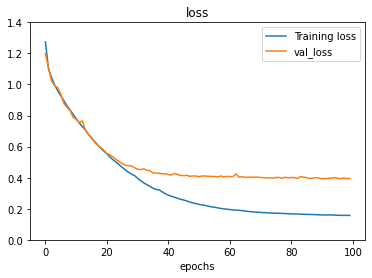

In [ ]:
tf = pd.read_csv("AttentionTrainRes50-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes50-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-3

In [ ]:
class Res50AttentionUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res50(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_res50_3 = AttentionUnet_3()
att_model_res50_3 = att_model_res50_3.to(device)
checkpoint_path_3 = "gdrive/Mydrive/AttentionModel-3.pth"

optimizer = torch.optim.Adam(att_model_res50_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res50_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res50_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res50_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 37s
	 Train Loss: 1.1758, train_iou: 0.7055, train_dice: 0.2728, train_accuracy: 0.9466, train_recall: 0.7874
	 Val. Loss: 1.1970, val_iou: 0.5790, val_dice: 0.2008, valid_accuracy: 0.9264, valid_recall: 0.1439

Epoch: 02 | Epoch Time: 0m 30s
	 Train Loss: 0.9569, train_iou: 0.7251, train_dice: 0.3464, train_accuracy: 0.9565, train_recall: 0.7597
	 Val. Loss: 0.9443, val_iou: 0.7401, val_dice: 0.3429, valid_accuracy: 0.9582, valid_recall: 0.7072

Epoch: 03 | Epoch Time: 0m 32s
	 Train Loss: 0.8893, train_iou: 0.7272, train_dice: 0.3785, train_accuracy: 0.9576, train_recall: 0.7622
	 Val. Loss: 0.8706, val_iou: 0.7367, val_dice: 0.3832, valid_accuracy: 0.9583, valid_recall: 0.7350

Epoch: 04 | Epoch Time: 0m 31s
	 Train Loss: 0.8434, train_iou: 0.7320, train_dice: 0.4009, train_accuracy: 0.9590, train_recall: 0.7607
	 Val. Loss: 0.8692, val_iou: 0.7081, val_dice: 0.3984, valid_accuracy: 0.9519, valid_recall: 0.7621

Epoch: 05 | Epoch Time: 0m 31s
	 Train Loss:

NameError: ignored

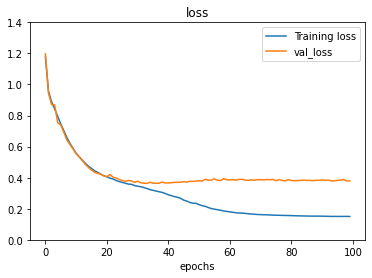

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes50-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes50-3.csv")

tf = pd.read_csv("AttentionTrainRes50-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes50-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

# Resnet34

## Model-1

In [ ]:
class Res34Unet(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
x = torch.randn((2,3,224,224))
x = x.to(device)
b = Unet()
b = b.to(device)
y = b(x)
y.shape

torch.Size([2, 1, 224, 224])

### Training

In [ ]:
model_res34_1 = Unet()
model_res34_1 = model_res34_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/Res34_Unet-1.pth"

optimizer = torch.optim.Adam(model_res34_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res34_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res34_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res34_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 11s
	 Train Loss: 1.3225, train_iou: 0.6901, train_dice: 0.2225, train_accuracy: 0.9365, train_recall: 0.6715
	 Val. Loss: 1.2723, val_iou: 0.6938, val_dice: 0.1970, valid_accuracy: 0.9416, valid_recall: 0.3299

Epoch: 02 | Epoch Time: 0m 12s
	 Train Loss: 1.1349, train_iou: 0.7078, train_dice: 0.2708, train_accuracy: 0.9471, train_recall: 0.6673
	 Val. Loss: 1.0616, val_iou: 0.7459, val_dice: 0.2814, valid_accuracy: 0.9550, valid_recall: 0.5991

Epoch: 03 | Epoch Time: 0m 11s
	 Train Loss: 1.0673, train_iou: 0.7033, train_dice: 0.2993, train_accuracy: 0.9472, train_recall: 0.6981
	 Val. Loss: 1.0513, val_iou: 0.7050, val_dice: 0.3057, valid_accuracy: 0.9480, valid_recall: 0.7067

Epoch: 04 | Epoch Time: 0m 11s
	 Train Loss: 1.0236, train_iou: 0.7037, train_dice: 0.3191, train_accuracy: 0.9482, train_recall: 0.7233
	 Val. Loss: 0.9860, val_iou: 0.7294, val_dice: 0.3276, valid_accuracy: 0.9552, valid_recall: 0.7079

Epoch: 05 | Epoch Time: 0m 11s
	 Train Loss:

## Model-2

In [ ]:
class Res34Unet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
model_res34_2 = Unet_2()
model_res34_2 = model_res34_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/Res34_Unet-2.pth"

optimizer = torch.optim.Adam(model_res34_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

### Training

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res34_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res34_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res34_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 27s
	 Train Loss: 1.2851, train_iou: 0.6982, train_dice: 0.2308, train_accuracy: 0.9441, train_recall: 0.6727
	 Val. Loss: 1.2619, val_iou: 0.6874, val_dice: 0.1998, valid_accuracy: 0.9402, valid_recall: 0.3119

Epoch: 02 | Epoch Time: 0m 17s
	 Train Loss: 1.1129, train_iou: 0.6959, train_dice: 0.2811, train_accuracy: 0.9444, train_recall: 0.6838
	 Val. Loss: 1.0665, val_iou: 0.7206, val_dice: 0.2896, valid_accuracy: 0.9513, valid_recall: 0.6565

Epoch: 03 | Epoch Time: 0m 17s
	 Train Loss: 1.0491, train_iou: 0.6976, train_dice: 0.3074, train_accuracy: 0.9462, train_recall: 0.7092
	 Val. Loss: 1.0409, val_iou: 0.6966, val_dice: 0.3146, valid_accuracy: 0.9459, valid_recall: 0.7394

Epoch: 04 | Epoch Time: 0m 21s
	 Train Loss: 1.0046, train_iou: 0.7049, train_dice: 0.3269, train_accuracy: 0.9488, train_recall: 0.7248
	 Val. Loss: 0.9790, val_iou: 0.7187, val_dice: 0.3347, valid_accuracy: 0.9531, valid_recall: 0.7263

Epoch: 05 | Epoch Time: 0m 16s
	 Train Loss:

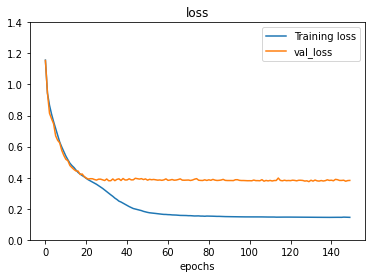

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validRes34-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainRes34-2.csv")

tf = pd.read_csv("trainRes34-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("validRes34-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-3

In [ ]:
class Res34Unet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_res34_3 = Unet_3()
model_res34_3 = model_res34_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/Res34_Unet-3.pth"

optimizer = torch.optim.Adam(model_res34_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res34_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_res34_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_res34_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 30s
	 Train Loss: 1.1568, train_iou: 0.6982, train_dice: 0.2634, train_accuracy: 0.9403, train_recall: 0.6392
	 Val. Loss: 1.1541, val_iou: 0.5867, val_dice: 0.2054, valid_accuracy: 0.9277, valid_recall: 0.1484

Epoch: 02 | Epoch Time: 0m 29s
	 Train Loss: 0.9438, train_iou: 0.7045, train_dice: 0.3474, train_accuracy: 0.9474, train_recall: 0.6932
	 Val. Loss: 0.9452, val_iou: 0.7030, val_dice: 0.3514, valid_accuracy: 0.9477, valid_recall: 0.7078

Epoch: 03 | Epoch Time: 0m 30s
	 Train Loss: 0.8664, train_iou: 0.7124, train_dice: 0.3875, train_accuracy: 0.9506, train_recall: 0.7150
	 Val. Loss: 0.8146, val_iou: 0.7446, val_dice: 0.4044, valid_accuracy: 0.9575, valid_recall: 0.6721

Epoch: 04 | Epoch Time: 0m 30s
	 Train Loss: 0.8094, train_iou: 0.7217, train_dice: 0.4181, train_accuracy: 0.9539, train_recall: 0.7233
	 Val. Loss: 0.7797, val_iou: 0.7449, val_dice: 0.4236, valid_accuracy: 0.9574, valid_recall: 0.6516

Epoch: 05 | Epoch Time: 0m 30s
	 Train Loss:

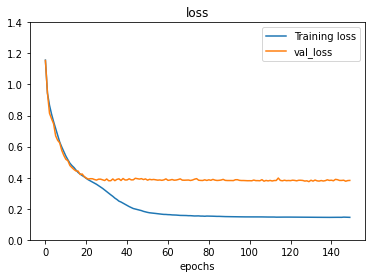

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validRes34-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainRes34-3.csv")

tf = pd.read_csv("trainRes34-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("validRes34-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-1

In [ ]:
class Res34AttentionUnet_1(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

In [ ]:
att_model_res34_1 = AttentionUnet_1()
att_model_res34_1 = att_model_res34_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelRes34-1.pth"

optimizer = torch.optim.Adam(att_model_res34_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

### Training

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res34_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res34_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res34_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 26s
	 Train Loss: 1.2578, train_iou: 0.7059, train_dice: 0.2309, train_accuracy: 0.9433, train_recall: 0.6185
	 Val. Loss: 1.2184, val_iou: 0.5145, val_dice: 0.1892, valid_accuracy: 0.9200, valid_recall: 0.0501

Epoch: 02 | Epoch Time: 0m 14s
	 Train Loss: 1.0671, train_iou: 0.7059, train_dice: 0.2954, train_accuracy: 0.9474, train_recall: 0.6791
	 Val. Loss: 1.0043, val_iou: 0.7494, val_dice: 0.3027, valid_accuracy: 0.9556, valid_recall: 0.5973

Epoch: 03 | Epoch Time: 0m 13s
	 Train Loss: 1.0035, train_iou: 0.7042, train_dice: 0.3251, train_accuracy: 0.9481, train_recall: 0.7115
	 Val. Loss: 0.9755, val_iou: 0.7175, val_dice: 0.3357, valid_accuracy: 0.9527, valid_recall: 0.7268

Epoch: 04 | Epoch Time: 0m 12s
	 Train Loss: 0.9621, train_iou: 0.7075, train_dice: 0.3451, train_accuracy: 0.9497, train_recall: 0.7277
	 Val. Loss: 0.9387, val_iou: 0.7097, val_dice: 0.3571, valid_accuracy: 0.9519, valid_recall: 0.7566

Epoch: 05 | Epoch Time: 0m 13s
	 Train Loss:

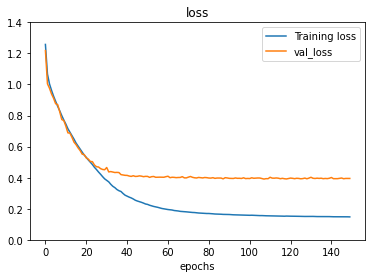

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes34-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes34-1.csv")

tf = pd.read_csv("AttentionTrainRes34-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes34-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-2

In [ ]:
class Res34AttentionUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_res34_2 = AttentionUnet_2()
att_model_res34_2 = att_model_res34_2.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelRes34-2.pth"

optimizer = torch.optim.Adam(att_model_res34_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res34_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res34_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res34_2.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 18s
	 Train Loss: 0.8322, train_iou: 0.7312, train_dice: 0.4089, train_accuracy: 0.9577, train_recall: 0.7523
	 Val. Loss: 0.8155, val_iou: 0.7379, val_dice: 0.4165, valid_accuracy: 0.9606, valid_recall: 0.7618

Epoch: 02 | Epoch Time: 0m 19s
	 Train Loss: 0.7955, train_iou: 0.7351, train_dice: 0.4290, train_accuracy: 0.9589, train_recall: 0.7558
	 Val. Loss: 0.7713, val_iou: 0.7571, val_dice: 0.4333, valid_accuracy: 0.9614, valid_recall: 0.7014

Epoch: 03 | Epoch Time: 0m 16s
	 Train Loss: 0.7617, train_iou: 0.7394, train_dice: 0.4481, train_accuracy: 0.9599, train_recall: 0.7552
	 Val. Loss: 0.7325, val_iou: 0.7553, val_dice: 0.4612, valid_accuracy: 0.9637, valid_recall: 0.7489

Epoch: 04 | Epoch Time: 0m 15s
	 Train Loss: 0.7281, train_iou: 0.7428, train_dice: 0.4686, train_accuracy: 0.9610, train_recall: 0.7596
	 Val. Loss: 0.7177, val_iou: 0.7476, val_dice: 0.4720, valid_accuracy: 0.9634, valid_recall: 0.7588

Epoch: 05 | Epoch Time: 0m 16s
	 Train Loss:

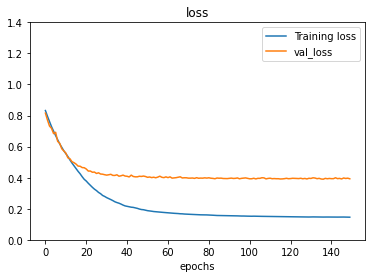

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes34-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes34-2.csv")

tf = pd.read_csv("AttentionTrainRes34-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes34-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-3

In [ ]:
class Res34AttentionUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_res34(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_res34_3 = AttentionUnet_3()
att_model_res34_3 = att_model_res34_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/AttentionModelRes34-3.pth"

optimizer = torch.optim.Adam(att_model_res34_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_res34_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_res34_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_res34_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 32s
	 Train Loss: 1.1298, train_iou: 0.6991, train_dice: 0.2796, train_accuracy: 0.9436, train_recall: 0.6718
	 Val. Loss: 1.1445, val_iou: 0.5967, val_dice: 0.2066, valid_accuracy: 0.9285, valid_recall: 0.1576

Epoch: 02 | Epoch Time: 0m 31s
	 Train Loss: 0.9267, train_iou: 0.7092, train_dice: 0.3579, train_accuracy: 0.9486, train_recall: 0.7039
	 Val. Loss: 0.8649, val_iou: 0.7317, val_dice: 0.3827, valid_accuracy: 0.9555, valid_recall: 0.7000

Epoch: 03 | Epoch Time: 0m 32s
	 Train Loss: 0.8563, train_iou: 0.7171, train_dice: 0.3930, train_accuracy: 0.9515, train_recall: 0.7095
	 Val. Loss: 0.8519, val_iou: 0.7221, val_dice: 0.3966, valid_accuracy: 0.9549, valid_recall: 0.7415

Epoch: 04 | Epoch Time: 0m 32s
	 Train Loss: 0.8000, train_iou: 0.7243, train_dice: 0.4247, train_accuracy: 0.9542, train_recall: 0.7242
	 Val. Loss: 0.7475, val_iou: 0.7511, val_dice: 0.4473, valid_accuracy: 0.9607, valid_recall: 0.7060

Epoch: 05 | Epoch Time: 0m 31s
	 Train Loss:

FileNotFoundError: ignored

In [ ]:
torch.save(att_model_res34_3.state_dict(), checkpoint_path_3)

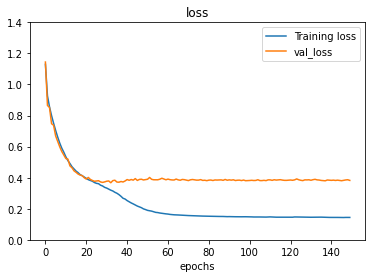

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidRes34-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainRes34-3.csv")

tf = pd.read_csv("AttentionTrainRes34-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidRes34-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

# Efficientnet

## Model-1

In [ ]:
class EffUnet(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_effb0_1 = Unet()
model_effb0_1 = model_effb0_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/EffB0_Unet-1.pth"

optimizer = torch.optim.Adam(model_effb0_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_effb0_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_effb0_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_effb0_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 17s
	 Train Loss: 1.3420, train_iou: 0.6754, train_dice: 0.2238, train_accuracy: 0.9312, train_recall: 0.7336
	 Val. Loss: 1.3028, val_iou: 0.7422, val_dice: 0.1980, valid_accuracy: 0.9510, valid_recall: 0.4760

Epoch: 02 | Epoch Time: 0m 13s
	 Train Loss: 1.1505, train_iou: 0.7078, train_dice: 0.2694, train_accuracy: 0.9478, train_recall: 0.6912
	 Val. Loss: 1.1403, val_iou: 0.7113, val_dice: 0.2718, valid_accuracy: 0.9494, valid_recall: 0.6865

Epoch: 03 | Epoch Time: 0m 13s
	 Train Loss: 1.0823, train_iou: 0.6975, train_dice: 0.2981, train_accuracy: 0.9464, train_recall: 0.7273
	 Val. Loss: 1.0599, val_iou: 0.7231, val_dice: 0.3001, valid_accuracy: 0.9538, valid_recall: 0.7110

Epoch: 04 | Epoch Time: 0m 12s
	 Train Loss: 1.0347, train_iou: 0.7046, train_dice: 0.3166, train_accuracy: 0.9490, train_recall: 0.7351
	 Val. Loss: 1.0055, val_iou: 0.7153, val_dice: 0.3245, valid_accuracy: 0.9523, valid_recall: 0.7269

Epoch: 05 | Epoch Time: 0m 12s
	 Train Loss:

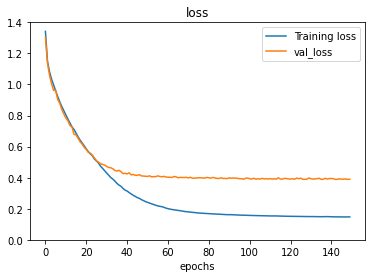

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validEffB0-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainEffB0-1.csv")

tf = pd.read_csv("trainEffB0-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("validEffB0-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-2

In [ ]:
class EffUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_effb0_2 = Unet_2()
model_effb0_2 = model_effb0_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/EffB0_Unet-2.pth"

optimizer = torch.optim.Adam(model_effb0_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

In [ ]:
v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_effb0_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_effb0_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_effb0_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 25s
	 Train Loss: 1.1993, train_iou: 0.7158, train_dice: 0.2524, train_accuracy: 0.9494, train_recall: 0.6741
	 Val. Loss: 1.1992, val_iou: 0.6356, val_dice: 0.2077, valid_accuracy: 0.9338, valid_recall: 0.2276

Epoch: 02 | Epoch Time: 0m 19s
	 Train Loss: 1.0355, train_iou: 0.7038, train_dice: 0.3122, train_accuracy: 0.9473, train_recall: 0.7012
	 Val. Loss: 0.9865, val_iou: 0.7253, val_dice: 0.3236, valid_accuracy: 0.9523, valid_recall: 0.6721

Epoch: 03 | Epoch Time: 0m 18s
	 Train Loss: 0.9726, train_iou: 0.7082, train_dice: 0.3381, train_accuracy: 0.9490, train_recall: 0.7122
	 Val. Loss: 0.9313, val_iou: 0.7294, val_dice: 0.3496, valid_accuracy: 0.9541, valid_recall: 0.6895

Epoch: 04 | Epoch Time: 0m 18s
	 Train Loss: 0.9302, train_iou: 0.7162, train_dice: 0.3569, train_accuracy: 0.9520, train_recall: 0.7201
	 Val. Loss: 0.9049, val_iou: 0.7318, val_dice: 0.3648, valid_accuracy: 0.9565, valid_recall: 0.7191

Epoch: 05 | Epoch Time: 0m 20s
	 Train Loss:

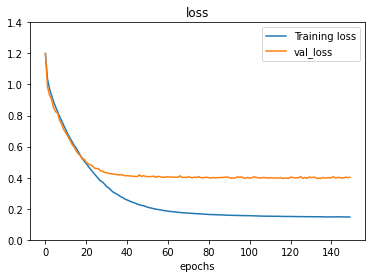

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validEffB0-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainEffB0-2.csv")

tf = pd.read_csv("trainEffB0-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("validEffB0-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-3

In [ ]:
class EffUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_effb0_3 = Unet_3()
model_effb0_3 = model_effb0_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/EffB0_Unet-3.pth"

optimizer = torch.optim.Adam(model_effb0_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_effb0_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_effb0_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_effb0_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 32s
	 Train Loss: 1.2787, train_iou: 0.6655, train_dice: 0.2398, train_accuracy: 0.9147, train_recall: 0.7081
	 Val. Loss: 1.5031, val_iou: 0.4599, val_dice: 0.2046, valid_accuracy: 0.7783, valid_recall: 0.8490

Epoch: 02 | Epoch Time: 0m 31s
	 Train Loss: 1.0517, train_iou: 0.6949, train_dice: 0.3085, train_accuracy: 0.9450, train_recall: 0.7216
	 Val. Loss: 1.0077, val_iou: 0.7168, val_dice: 0.3201, valid_accuracy: 0.9520, valid_recall: 0.7109

Epoch: 03 | Epoch Time: 0m 31s
	 Train Loss: 0.9719, train_iou: 0.7033, train_dice: 0.3417, train_accuracy: 0.9488, train_recall: 0.7359
	 Val. Loss: 0.9190, val_iou: 0.7383, val_dice: 0.3551, valid_accuracy: 0.9573, valid_recall: 0.7028

Epoch: 04 | Epoch Time: 0m 32s
	 Train Loss: 0.9147, train_iou: 0.7128, train_dice: 0.3673, train_accuracy: 0.9517, train_recall: 0.7354
	 Val. Loss: 0.8860, val_iou: 0.7297, val_dice: 0.3778, valid_accuracy: 0.9566, valid_recall: 0.7363

Epoch: 05 | Epoch Time: 0m 31s
	 Train Loss:

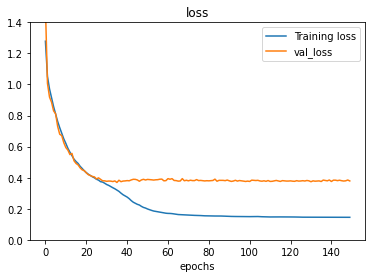

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validEffB0-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainEffB0-3.csv")

tf = pd.read_csv("trainEffB0-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("validEffB0-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-1

In [ ]:
class EffAttentionUnet_1(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = attention_decoder(1024, 512)
    self.d2 = attention_decoder(512, 256)
    self.d3 = attention_decoder(256, 128)
    self.d4 = attention_decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_effb0_1 = AttentionUnet_1()
att_model_effb0_1 = att_model_effb0_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelEffB0-1.pth"

optimizer = torch.optim.Adam(att_model_effb0_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_effb0_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_effb0_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_effb0_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 22s
	 Train Loss: 1.3060, train_iou: 0.6865, train_dice: 0.2313, train_accuracy: 0.9404, train_recall: 0.7155
	 Val. Loss: 1.2693, val_iou: 0.6389, val_dice: 0.1956, valid_accuracy: 0.9339, valid_recall: 0.2286

Epoch: 02 | Epoch Time: 0m 16s
	 Train Loss: 1.1206, train_iou: 0.6934, train_dice: 0.2865, train_accuracy: 0.9446, train_recall: 0.7231
	 Val. Loss: 1.0904, val_iou: 0.7023, val_dice: 0.2912, valid_accuracy: 0.9466, valid_recall: 0.6963

Epoch: 03 | Epoch Time: 0m 15s
	 Train Loss: 1.0487, train_iou: 0.7016, train_dice: 0.3114, train_accuracy: 0.9479, train_recall: 0.7336
	 Val. Loss: 1.0168, val_iou: 0.7144, val_dice: 0.3201, valid_accuracy: 0.9527, valid_recall: 0.7334

Epoch: 04 | Epoch Time: 0m 19s
	 Train Loss: 1.0021, train_iou: 0.7066, train_dice: 0.3307, train_accuracy: 0.9503, train_recall: 0.7481
	 Val. Loss: 0.9776, val_iou: 0.7154, val_dice: 0.3384, valid_accuracy: 0.9529, valid_recall: 0.7443

Epoch: 05 | Epoch Time: 0m 14s
	 Train Loss:

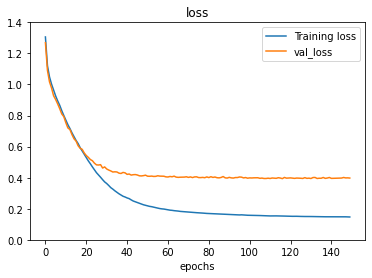

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidEffB0-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainEffB0-1.csv")

tf = pd.read_csv("AttentionTrainEffB0-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidEffB0-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-2

In [ ]:
class EffAttentionUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = attention_decoder(2048, 1024)
    self.d2 = attention_decoder(1024, 512)
    self.d3 = attention_decoder(512, 256)
    self.d4 = attention_decoder(256, 128)
    self.d5 = attention_decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_effb0_2 = AttentionUnet_2()
att_model_effb0_2 = att_model_effb0_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/AttentionModelEffB0-2.pth"

optimizer = torch.optim.Adam(att_model_effb0_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_effb0_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_effb0_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_effb0_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 18s
	 Train Loss: 1.2120, train_iou: 0.6811, train_dice: 0.2561, train_accuracy: 0.9388, train_recall: 0.6913
	 Val. Loss: 1.1908, val_iou: 0.6296, val_dice: 0.2100, valid_accuracy: 0.9332, valid_recall: 0.2199

Epoch: 02 | Epoch Time: 0m 18s
	 Train Loss: 1.0253, train_iou: 0.7023, train_dice: 0.3196, train_accuracy: 0.9475, train_recall: 0.7046
	 Val. Loss: 1.0241, val_iou: 0.7071, val_dice: 0.3130, valid_accuracy: 0.9486, valid_recall: 0.6884

Epoch: 03 | Epoch Time: 0m 18s
	 Train Loss: 0.9594, train_iou: 0.7090, train_dice: 0.3460, train_accuracy: 0.9502, train_recall: 0.7182
	 Val. Loss: 0.9372, val_iou: 0.7228, val_dice: 0.3515, valid_accuracy: 0.9541, valid_recall: 0.7117

Epoch: 04 | Epoch Time: 0m 15s
	 Train Loss: 0.9175, train_iou: 0.7177, train_dice: 0.3641, train_accuracy: 0.9526, train_recall: 0.7219
	 Val. Loss: 0.8795, val_iou: 0.7483, val_dice: 0.3688, valid_accuracy: 0.9578, valid_recall: 0.6560

Epoch: 05 | Epoch Time: 0m 15s
	 Train Loss:

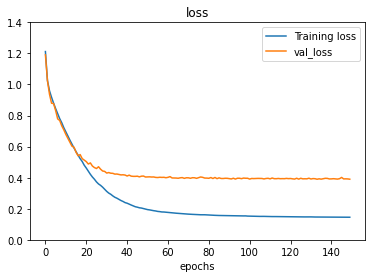

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidEffB0-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainEffB0-2.csv")

tf = pd.read_csv("AttentionTrainEffB0-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidEffB0-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-Unet-3

In [ ]:
class EffAttentionUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = attention_decoder(2048, 1024)
    self.d2 = attention_decoder(1024, 512)
    self.d3 = attention_decoder(512, 256)
    self.d4 = attention_decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_effb0(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_effb0_3 = AttentionUnet_3()
att_model_effb0_3 = att_model_effb0_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/AttentionModelEffB0-3.pth"

optimizer = torch.optim.Adam(att_model_effb0_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_effb0_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_effb0_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_effb0_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 35s
	 Train Loss: 1.1324, train_iou: 0.7046, train_dice: 0.2749, train_accuracy: 0.9428, train_recall: 0.6737
	 Val. Loss: 1.1501, val_iou: 0.6026, val_dice: 0.2093, valid_accuracy: 0.9297, valid_recall: 0.1792

Epoch: 02 | Epoch Time: 0m 27s
	 Train Loss: 0.9362, train_iou: 0.7077, train_dice: 0.3524, train_accuracy: 0.9488, train_recall: 0.7127
	 Val. Loss: 0.9035, val_iou: 0.7272, val_dice: 0.3677, valid_accuracy: 0.9540, valid_recall: 0.7058

Epoch: 03 | Epoch Time: 0m 28s
	 Train Loss: 0.8789, train_iou: 0.7108, train_dice: 0.3829, train_accuracy: 0.9504, train_recall: 0.7277
	 Val. Loss: 0.8189, val_iou: 0.7452, val_dice: 0.4038, valid_accuracy: 0.9583, valid_recall: 0.6878

Epoch: 04 | Epoch Time: 0m 28s
	 Train Loss: 0.8200, train_iou: 0.7188, train_dice: 0.4142, train_accuracy: 0.9533, train_recall: 0.7377
	 Val. Loss: 0.7833, val_iou: 0.7395, val_dice: 0.4279, valid_accuracy: 0.9581, valid_recall: 0.7173

Epoch: 05 | Epoch Time: 0m 28s
	 Train Loss:

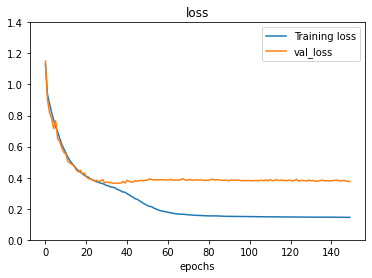

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidEffB0-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainEffB0-3.csv")

tf = pd.read_csv("AttentionTrainEffB0-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidEffB0-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

# MobileV2

## Model-1

In [ ]:
class MobileUnet(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = decoder(1024, 512)
    self.d2 = decoder(512, 256)
    self.d3 = decoder(256, 128)
    self.d4 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_mobv2_1 = Unet()
model_mobv2_1 = model_mobv2_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/MobileV2_Unet-1.pth"

optimizer = torch.optim.Adam(model_mobv2_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_mobv2_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_mobv2_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_mobv2_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 17s
	 Train Loss: 1.2893, train_iou: 0.6905, train_dice: 0.2299, train_accuracy: 0.9389, train_recall: 0.6907
	 Val. Loss: 1.2260, val_iou: 0.5387, val_dice: 0.1915, valid_accuracy: 0.9226, valid_recall: 0.0878

Epoch: 02 | Epoch Time: 0m 13s
	 Train Loss: 1.0925, train_iou: 0.7044, train_dice: 0.2887, train_accuracy: 0.9474, train_recall: 0.7032
	 Val. Loss: 1.0464, val_iou: 0.7316, val_dice: 0.3000, valid_accuracy: 0.9549, valid_recall: 0.6926

Epoch: 03 | Epoch Time: 0m 14s
	 Train Loss: 1.0208, train_iou: 0.7096, train_dice: 0.3193, train_accuracy: 0.9502, train_recall: 0.7286
	 Val. Loss: 1.0033, val_iou: 0.7097, val_dice: 0.3276, valid_accuracy: 0.9506, valid_recall: 0.7464

Epoch: 04 | Epoch Time: 0m 14s
	 Train Loss: 0.9749, train_iou: 0.7133, train_dice: 0.3399, train_accuracy: 0.9519, train_recall: 0.7420
	 Val. Loss: 0.9298, val_iou: 0.7397, val_dice: 0.3513, valid_accuracy: 0.9582, valid_recall: 0.7145

Epoch: 05 | Epoch Time: 0m 15s
	 Train Loss:

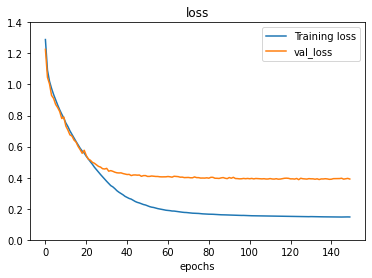

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validMobileV2-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainMobileV2-1.csv")

tf = pd.read_csv("trainMobileV2-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("validMobileV2-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-2

In [ ]:
class MobileUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)
    self.d5 = decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_mobv2_2 = Unet_2()
model_mobv2_2 = model_mobv2_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/MobileV2_Unet-2.pth"

optimizer = torch.optim.Adam(model_mobv2_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_mobv2_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_mobv2_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_mobv2_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 17s
	 Train Loss: 1.2140, train_iou: 0.7293, train_dice: 0.2358, train_accuracy: 0.9512, train_recall: 0.6250
	 Val. Loss: 1.1936, val_iou: 0.5634, val_dice: 0.2033, valid_accuracy: 0.9246, valid_recall: 0.1216

Epoch: 02 | Epoch Time: 0m 16s
	 Train Loss: 1.0331, train_iou: 0.7264, train_dice: 0.3028, train_accuracy: 0.9526, train_recall: 0.6702
	 Val. Loss: 0.9694, val_iou: 0.7467, val_dice: 0.3233, valid_accuracy: 0.9565, valid_recall: 0.6454

Epoch: 03 | Epoch Time: 0m 16s
	 Train Loss: 0.9651, train_iou: 0.7187, train_dice: 0.3367, train_accuracy: 0.9519, train_recall: 0.7005
	 Val. Loss: 0.9880, val_iou: 0.7067, val_dice: 0.3335, valid_accuracy: 0.9501, valid_recall: 0.7415

Epoch: 04 | Epoch Time: 0m 16s
	 Train Loss: 0.9258, train_iou: 0.7170, train_dice: 0.3578, train_accuracy: 0.9519, train_recall: 0.7166
	 Val. Loss: 0.9299, val_iou: 0.7146, val_dice: 0.3594, valid_accuracy: 0.9526, valid_recall: 0.7441

Epoch: 05 | Epoch Time: 0m 15s
	 Train Loss:

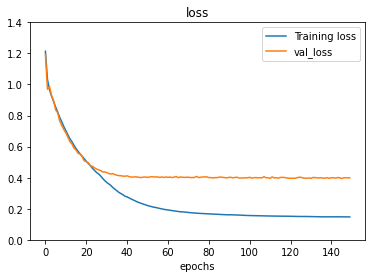

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validMobileV2-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainMobileV2-2.csv")

tf = pd.read_csv("trainMobileV2-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("validMobileV2-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Model-3

In [ ]:
class MobileUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = decoder(2048, 1024)
    self.d2 = decoder(1024, 512)
    self.d3 = decoder(512, 256)
    self.d4 = decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
model_mobv2_3 = Unet_3()
model_mobv2_3 = model_mobv2_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/MobV2_Unet-3.pth"

optimizer = torch.optim.Adam(model_mobv2_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(150):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_mobv2_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(model_mobv2_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(model_mobv2_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 32s
	 Train Loss: 1.1652, train_iou: 0.7000, train_dice: 0.2701, train_accuracy: 0.9444, train_recall: 0.7010
	 Val. Loss: 1.1447, val_iou: 0.5314, val_dice: 0.1995, valid_accuracy: 0.9215, valid_recall: 0.0687

Epoch: 02 | Epoch Time: 0m 33s
	 Train Loss: 0.9508, train_iou: 0.7094, train_dice: 0.3478, train_accuracy: 0.9495, train_recall: 0.7178
	 Val. Loss: 0.9523, val_iou: 0.6940, val_dice: 0.3532, valid_accuracy: 0.9452, valid_recall: 0.7454

Epoch: 03 | Epoch Time: 0m 31s
	 Train Loss: 0.8750, train_iou: 0.7196, train_dice: 0.3846, train_accuracy: 0.9535, train_recall: 0.7320
	 Val. Loss: 0.8353, val_iou: 0.7339, val_dice: 0.4018, valid_accuracy: 0.9578, valid_recall: 0.7341

Epoch: 04 | Epoch Time: 0m 32s
	 Train Loss: 0.8178, train_iou: 0.7234, train_dice: 0.4157, train_accuracy: 0.9556, train_recall: 0.7440
	 Val. Loss: 0.7724, val_iou: 0.7408, val_dice: 0.4375, valid_accuracy: 0.9600, valid_recall: 0.7408

Epoch: 05 | Epoch Time: 0m 32s
	 Train Loss:

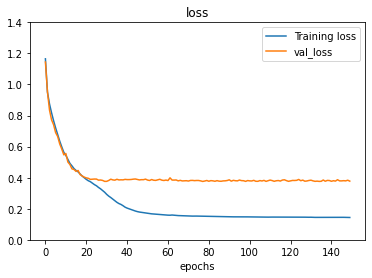

In [ ]:
import pandas as pd

train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("validMobV2-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("trainMobV2-3.csv")

tf = pd.read_csv("trainMobV2-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("validMobV2-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-1

In [ ]:
class MobileAttentionUnet_1(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)

    """ Bridge Layer """
    self.b = conv_block(512, 1024)

    """ Decoder """
    self.d1 = attention_decoder(1024, 512)
    self.d2 = attention_decoder(512, 256)
    self.d3 = attention_decoder(256, 128)
    self.d4 = attention_decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_mobv2_1 = AttentionUnet_1()
att_model_mobv2_1 = att_model_mobv2_1.to(device)
checkpoint_path_1 = "gdrive/MyDrive/AttentionModelMobV2-1.pth"

optimizer = torch.optim.Adam(att_model_mobv2_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_mobv2_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_mobv2_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_mobv2_1.state_dict(), checkpoint_path_1)

Epoch: 01 | Epoch Time: 0m 22s
	 Train Loss: 1.2987, train_iou: 0.6897, train_dice: 0.2308, train_accuracy: 0.9383, train_recall: 0.7122
	 Val. Loss: 1.3307, val_iou: 0.6115, val_dice: 0.1827, valid_accuracy: 0.9306, valid_recall: 0.1893

Epoch: 02 | Epoch Time: 0m 12s
	 Train Loss: 1.1146, train_iou: 0.7033, train_dice: 0.2853, train_accuracy: 0.9481, train_recall: 0.7286
	 Val. Loss: 1.0962, val_iou: 0.7036, val_dice: 0.2913, valid_accuracy: 0.9475, valid_recall: 0.7348

Epoch: 03 | Epoch Time: 0m 10s
	 Train Loss: 1.0496, train_iou: 0.6958, train_dice: 0.3123, train_accuracy: 0.9470, train_recall: 0.7483
	 Val. Loss: 1.0342, val_iou: 0.7019, val_dice: 0.3189, valid_accuracy: 0.9489, valid_recall: 0.7564

Epoch: 04 | Epoch Time: 0m 11s
	 Train Loss: 1.0039, train_iou: 0.7072, train_dice: 0.3294, train_accuracy: 0.9508, train_recall: 0.7480
	 Val. Loss: 0.9729, val_iou: 0.7121, val_dice: 0.3414, valid_accuracy: 0.9523, valid_recall: 0.7504

Epoch: 05 | Epoch Time: 0m 10s
	 Train Loss:

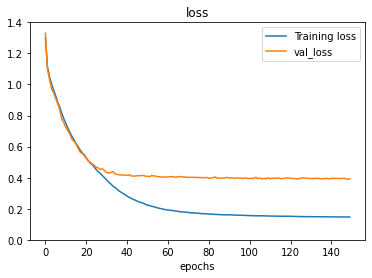

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidMobV2-1.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainMobV2-1.csv")

tf = pd.read_csv("AttentionTrainMobV2-1.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidMobV2-1.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-2

In [ ]:
class MobileAttentionUnet_2(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 64)
    self.e2 = encoder(64, 128)
    self.e3 = encoder(128, 256)
    self.e4 = encoder(256, 512)
    self.e5 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = attention_decoder(2048, 1024)
    self.d2 = attention_decoder(1024, 512)
    self.d3 = attention_decoder(512, 256)
    self.d4 = attention_decoder(256, 128)
    self.d5 = attention_decoder(128, 64)

    """ Output """
    self.outputs = nn.Conv2d(64, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)
    s5, p5 = self.e5(p4)

    """ Bridge """
    b = self.b(p5)

    """ Decoder """
    d1 = self.d1(b, s5)
    d2 = self.d2(d1, s4)
    d3 = self.d3(d2, s3)
    d4 = self.d4(d3, s2)
    d5 = self.d5(d4, s1)

    """ Output """
    outputs = self.outputs(d5)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_mobv2_2 = AttentionUnet_2()
att_model_mobv2_2 = att_model_mobv2_2.to(device)
checkpoint_path_2 = "gdrive/MyDrive/AttentionModelMobV2-2.pth"

optimizer = torch.optim.Adam(att_model_mobv2_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_mobv2_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_mobv2_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

torch.save(att_model_mobv2_2.state_dict(), checkpoint_path_2)

Epoch: 01 | Epoch Time: 0m 15s
	 Train Loss: 1.2367, train_iou: 0.7125, train_dice: 0.2437, train_accuracy: 0.9492, train_recall: 0.6965
	 Val. Loss: 1.1495, val_iou: 0.5900, val_dice: 0.2148, valid_accuracy: 0.9280, valid_recall: 0.1525

Epoch: 02 | Epoch Time: 0m 14s
	 Train Loss: 1.0581, train_iou: 0.7080, train_dice: 0.3023, train_accuracy: 0.9493, train_recall: 0.7108
	 Val. Loss: 1.0147, val_iou: 0.7200, val_dice: 0.3168, valid_accuracy: 0.9530, valid_recall: 0.7109

Epoch: 03 | Epoch Time: 0m 14s
	 Train Loss: 0.9993, train_iou: 0.7089, train_dice: 0.3279, train_accuracy: 0.9504, train_recall: 0.7284
	 Val. Loss: 0.9758, val_iou: 0.7170, val_dice: 0.3370, valid_accuracy: 0.9533, valid_recall: 0.7345

Epoch: 04 | Epoch Time: 0m 14s
	 Train Loss: 0.9584, train_iou: 0.7153, train_dice: 0.3458, train_accuracy: 0.9527, train_recall: 0.7350
	 Val. Loss: 0.9489, val_iou: 0.7190, val_dice: 0.3469, valid_accuracy: 0.9536, valid_recall: 0.7270

Epoch: 05 | Epoch Time: 0m 15s
	 Train Loss:

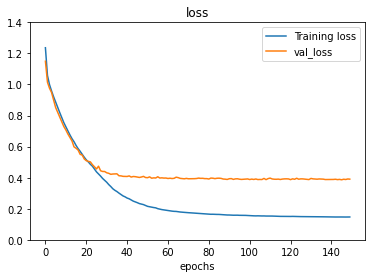

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidMobV2-2.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainMobV2-2.csv")

tf = pd.read_csv("AttentionTrainMobV2-2.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidMobV2-2.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

## Attention-3

In [ ]:
class MobileAttentionUnet_3(nn.Module):
  def __init__(self):
    super().__init__()

    """ Encoder """
    self.e1 = encoder(3, 128)
    self.e2 = encoder(128, 256)
    self.e3 = encoder(256, 512)
    self.e4 = encoder(512, 1024)

    """ Bridge Layer """
    self.b = conv_block(1024, 2048)

    """ Decoder """
    self.d1 = attention_decoder(2048, 1024)
    self.d2 = attention_decoder(1024, 512)
    self.d3 = attention_decoder(512, 256)
    self.d4 = attention_decoder(256, 128)

    """ Output """
    self.outputs = nn.Conv2d(128, 1, kernel_size =1, padding=0)

  def forward(self, inputs):
    """ Encoder """
    s1, p1 = self.e1(inputs)
    s2, p2 = self.e2(p1)
    s3, p3 = self.e3(p2)
    s4, p4 = self.e4(p3)

    """ Bridge """
    b = self.b(p4)

    """ Decoder """
    d1 = self.d1(b, s4)
    d2 = self.d2(d1, s3)
    d3 = self.d3(d2, s2)
    d4 = self.d4(d3, s1)

    """ Output """
    outputs = self.outputs(d4)
    y = model_mobv2(inputs)
    mask = torch.add(outputs, y)
    return mask

### Training

In [ ]:
att_model_mobv2_3 = MobileAttentionUnet_3()
att_model_mobv2_3 = att_model_mobv2_3.to(device)
checkpoint_path_3 = "gdrive/MyDrive/AttentionModelMobV2-3.pth"

optimizer = torch.optim.Adam(att_model_mobv2_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

v_loss, t_loss = [], []
v_iou, t_iou = [], []
v_dice, t_dice = [], []
v_acc, t_acc = [], []
v_rec, t_rec = [], []

# Training model
best_valid_loss = float("inf")

for epoch in range(num_epochs):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(att_model_mobv2_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall = evaluate(att_model_mobv2_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  t_loss.append(train_loss)
  t_iou.append(train_iou)
  t_dice.append(train_dice)
  t_acc.append(train_acc)
  t_rec.append(train_recall)

  v_loss.append(valid_loss)
  v_iou.append(valid_iou)
  v_dice.append(valid_dice)
  v_acc.append(valid_acc)
  v_rec.append(valid_recall)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, valid_recall: {valid_recall:.4f}\n'
  print(data_str)

# torch.save(att_model_mobv2_3.state_dict(), checkpoint_path_3)

Epoch: 01 | Epoch Time: 0m 41s
	 Train Loss: 1.1158, train_iou: 0.7102, train_dice: 0.2810, train_accuracy: 0.9468, train_recall: 0.6638
	 Val. Loss: 1.1133, val_iou: 0.5292, val_dice: 0.2083, valid_accuracy: 0.9210, valid_recall: 0.0667

Epoch: 02 | Epoch Time: 0m 29s
	 Train Loss: 0.9284, train_iou: 0.7114, train_dice: 0.3550, train_accuracy: 0.9493, train_recall: 0.6893
	 Val. Loss: 0.9203, val_iou: 0.7150, val_dice: 0.3617, valid_accuracy: 0.9521, valid_recall: 0.7240

Epoch: 03 | Epoch Time: 0m 29s
	 Train Loss: 0.8496, train_iou: 0.7198, train_dice: 0.3961, train_accuracy: 0.9527, train_recall: 0.7108
	 Val. Loss: 0.8181, val_iou: 0.7512, val_dice: 0.4001, valid_accuracy: 0.9583, valid_recall: 0.6563

Epoch: 04 | Epoch Time: 0m 29s
	 Train Loss: 0.7944, train_iou: 0.7299, train_dice: 0.4252, train_accuracy: 0.9554, train_recall: 0.7072
	 Val. Loss: 0.7489, val_iou: 0.7454, val_dice: 0.4469, valid_accuracy: 0.9594, valid_recall: 0.7013

Epoch: 05 | Epoch Time: 0m 29s
	 Train Loss:

In [ ]:
import pandas as pd
train_iou = []
valid_iou = []
for i in t_iou:
  i = i.detach().cpu().numpy()
  train_iou.append(i)

for i in v_iou:
  i = i.detach().cpu().numpy()
  valid_iou.append(i)

dic = {"Train Loss": t_loss, "Train IOU": train_iou, "Train Dice": t_dice, "Train Accuracy": t_acc, "Train Recall": t_rec}

val = {"Valid Loss": v_loss, "Valid IOU": valid_iou, "valid Dice": v_dice, "valid Accuracy": v_acc, "valid Recall": v_rec}
df = pd.DataFrame(val)

df.to_csv("AttentionValidMobV2-3.csv")
tf = pd.DataFrame(dic)
tf.to_csv("AttentionTrainMobV2-3.csv")

tf = pd.read_csv("AttentionTrainMobV2-3.csv")["Train Loss"].tolist()
vf = pd.read_csv("AttentionValidMobV2-3.csv")["Valid Loss"].tolist()

plot_loss(vf, tf)

# Testing Models

## Res50-1

In [ ]:
model_res50_1 = Res50Unet()
model_res50_1.load_state_dict(torch.load("gdrive/MyDrive/Res50_Unet-1.pth"))
dice = DiceScore()
model_res50_1.to(device)
test(model_res50_1, dice)

100%|██████████| 20/20 [00:03<00:00,  5.90it/s]

Jaccard: 0.6467 - F1-Score: 0.7852 - Recall: 0.7648  - iou_score: 0.7648 -  dice: 0.7530 - Precision: 0.8101 - Acc: 0.9651 AUC-ROC: 0.8743


In [ ]:
optimizer = torch.optim.Adam(model_res50_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

for epoch in range(1):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall, f1, auc = evaluate(model_res50_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, F1: {f1:.4f} AUC: {auc:.4f} valid_recall: {valid_recall:.4f}\n'
  print(data_str)

Epoch: 01 | Epoch Time: 0m 19s
	 Train Loss: 0.2323, train_iou: 0.7825, train_dice: 0.8427, train_accuracy: 0.9851, train_recall: 0.8959
	 Val. Loss: 0.3963, val_iou: 0.7790, val_dice: 0.7397, valid_accuracy: 0.9651, F1: 0.7692 AUC: 0.8426 valid_recall: 0.6952



## Res50-2

In [ ]:
model_res50_2 = Res50Unet_2()
model_res50_2.load_state_dict(torch.load("gdrive/MyDrive/Res50_Unet-2.pth"))
dice = DiceScore()
model_res50_2.to(device)
test(model_res50_2, dice)

100%|██████████| 20/20 [00:05<00:00,  3.95it/s]

Jaccard: 0.6435 - F1-Score: 0.7828 - Recall: 0.7698  - iou_score: 0.7590 -  dice: 0.7530 - Precision: 0.7998 - Acc: 0.9644 AUC-ROC: 0.8762


In [ ]:
optimizer = torch.optim.Adam(model_res50_2.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

for epoch in range(1):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_2, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall, f1, auc = evaluate(model_res50_2, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, F1: {f1:.4f} AUC: {auc:.4f} valid_recall: {valid_recall:.4f}\n'
  print(data_str)

Epoch: 01 | Epoch Time: 0m 23s
	 Train Loss: 0.2353, train_iou: 0.7815, train_dice: 0.8422, train_accuracy: 0.9848, train_recall: 0.8949
	 Val. Loss: 0.3761, val_iou: 0.7660, val_dice: 0.7564, valid_accuracy: 0.9664, F1: 0.7896 AUC: 0.8706 valid_recall: 0.7554



## Res50-3

In [ ]:
model_res50_3 = Res50Unet_3()
model_res50_3.load_state_dict(torch.load("gdrive/MyDrive/Res50_Unet-3.pth"))
model_res50_3.to(device)
dice = DiceScore()

In [ ]:
test(model_res50_3, dice)

100%|██████████| 20/20 [00:03<00:00,  5.81it/s]

Jaccard: 0.6587 - F1-Score: 0.7940 - Recall: 0.7634  - iou_score: 0.7755 -  dice: 0.7626 - Precision: 0.8308 - Acc: 0.9670 AUC-ROC: 0.8747


In [ ]:
optimizer = torch.optim.Adam(model_res50_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

for epoch in range(1):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(model_res50_3, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall, f1, auc = evaluate(model_res50_3, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, F1: {f1:.4f} AUC: {auc:.4f} valid_recall: {valid_recall:.4f}\n'
  print(data_str)

Epoch: 01 | Epoch Time: 0m 30s
	 Train Loss: 0.1815, train_iou: 0.7889, train_dice: 0.8774, train_accuracy: 0.9911, train_recall: 0.9425
	 Val. Loss: 0.3866, val_iou: 0.7738, val_dice: 0.7547, valid_accuracy: 0.9663, F1: 0.7822 AUC: 0.8566 valid_recall: 0.7246



In [ ]:
optimizer = torch.optim.Adam(model_res50_3.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()
epoch_loss = 0.0
iou_score = 0.0
dice_score = 0.0
acc = 0.0
recall = 0.0
f1 = 0.0
auc = 0.0

model_res50_3.eval()
with torch.no_grad():
  for x,y in valid_loader:
    x = x.to(device, dtype = torch.float32)
    y = y.to(device, dtype = torch.float32)

    y_pred = model_res50_3(x)
    loss = loss_fn(y_pred, y )
    DICE = dice(y_pred, y)

    y_true = y
    pred_y = y_pred

    accurate, rec = accuracy_recall(y_true, pred_y)
    acc += accurate
    recall += rec

    y_p = y_pred.cpu().numpy() > 0.5
    y_t = y_true.cpu().numpy() > 0.5
    y_t = y_t.astype(np.uint8)
    y_t = y_t.reshape(-1)
    y_p = y_p.astype(np.uint8)
    y_p = y_p.reshape(-1)
    print(type(y_p), type(y_t))
    f = f1_score(y_t, y_p)
    auc_roc = roc_auc_score(y_t, y_p )
    f1 += f
    auc += auc_roc

    y1 = y.int()
    jaccard = JaccardIndex(num_classes=2).to(device)
    iou = jaccard(y_pred, y1)
    iou = iou.float()

    epoch_loss += loss.item()
    iou_score += iou
    dice_score += DICE.item()

  # metrics = [smp.utils.metrics.IoU(threshold=0.5)]
  epoch_loss = epoch_loss/len(valid_loader)
  iou_score = iou_score/ len(valid_loader)
  dice_score = dice_score/len(valid_loader)
  acc = acc/len(valid_loader)
  recall = recall/len(valid_loader)
  f1 = f1/len(valid_loader)
  auc = auc/len(valid_loader)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


## Res50 Attention-1

In [ ]:
modelRes50_att_1 = Res50AttentionUnet_1()
modelRes50_att_1.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes50-1.pth"))
dice = DiceScore()
modelRes50_att_1.to(device)
test(modelRes50_att_1, dice)

100%|██████████| 20/20 [00:05<00:00,  3.96it/s]

Jaccard: 0.6479 - F1-Score: 0.7861 - Recall: 0.7690  - iou_score: 0.7640 -  dice: 0.7565 - Precision: 0.8073 - Acc: 0.9651 AUC-ROC: 0.8762


In [ ]:
optimizer = torch.optim.Adam(modelRes50_att_1.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5, verbose=True)
loss_fn = DiceBCELoss()
dice = DiceScore()

for epoch in range(1):
  start_time = time.time()

  train_loss, train_iou, train_dice, train_acc, train_recall = train(modelRes50_att_1, train_loader, optimizer, loss_fn, device, dice)
  valid_loss, valid_iou, valid_dice, valid_acc, valid_recall, f1, auc = evaluate(modelRes50_att_1, valid_loader, loss_fn, device, dice)
  end_time = time.time()
  epoch_min, epoch_sec = epoch_time(start_time, end_time)

  data_str = f'Epoch: {epoch+1:02} | Epoch Time: {epoch_min}m {epoch_sec}s\n' 
  data_str += f'\t Train Loss: {train_loss:.4f}, train_iou: {train_iou:.4f}, train_dice: {train_dice:.4f}, train_accuracy: {train_acc:.4f}, train_recall: {train_recall:.4f}\n'
  data_str += f'\t Val. Loss: {valid_loss:.4f}, val_iou: {valid_iou:.4f}, val_dice: {valid_dice:.4f}, valid_accuracy: {valid_acc:.4f}, F1: {f1:.4f} AUC: {auc:.4f} valid_recall: {valid_recall:.4f}\n'
  print(data_str)

Epoch: 01 | Epoch Time: 0m 17s
	 Train Loss: 0.2272, train_iou: 0.7834, train_dice: 0.8471, train_accuracy: 0.9855, train_recall: 0.8977
	 Val. Loss: 0.3889, val_iou: 0.7585, val_dice: 0.7576, valid_accuracy: 0.9654, F1: 0.7871 AUC: 0.8746 valid_recall: 0.7654



## Res50 Attention-2

In [ ]:
modelRes50_att_1 = Res50AttentionUnet_2()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes50-2.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:04<00:00,  3.25s/it]

Jaccard: 0.6334 - F1-Score: 0.7752 - Recall: 0.7687  - iou_score: 0.7544 -  dice: 0.7391 - Precision: 0.7860 - Acc: 0.9629 AUC-ROC: 0.8749


## Res50 Attention-3

In [ ]:
model = Res50AttentionUnet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes34-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [02:10<00:00,  6.53s/it]

Jaccard: 0.0819 - F1-Score: 0.1512 - Recall: 0.9273  - iou_score: 0.2524 -  dice: 0.1443 - Precision: 0.0824 - Acc: 0.1261 AUC-ROC: 0.4899


## Res34 

### Model-3

In [ ]:
model = Res34Unet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/Res34_Unet-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:57<00:00,  5.86s/it]

Jaccard: 0.6650 - F1-Score: 0.7986 - Recall: 0.7863  - iou_score: 0.7694 -  dice: 0.7670 - Precision: 0.8146 - Acc: 0.9669 AUC-ROC: 0.8851


### Attention-1

In [ ]:
model = Res34AttentionUnet_1()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes34-1.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

RuntimeError: ignored

### Attention-2

In [ ]:
model = Res34AttentionUnet_2()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes34-2.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:01<00:00,  3.09s/it]

Jaccard: 0.6484 - F1-Score: 0.7864 - Recall: 0.7731  - iou_score: 0.7640 -  dice: 0.7569 - Precision: 0.8037 - Acc: 0.9650 AUC-ROC: 0.8780


### Attention-3

In [ ]:
model = Res34AttentionUnet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelRes34-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:38<00:00,  4.91s/it]

Jaccard: 0.1661 - F1-Score: 0.2845 - Recall: 0.7862  - iou_score: 0.6824 -  dice: 0.1776 - Precision: 0.1742 - Acc: 0.6691 AUC-ROC: 0.7224


## EfficientNet

### Model-3

In [ ]:
model = EffUnet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/EffB0_Unet-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:33<00:00,  4.65s/it]

Jaccard: 0.6666 - F1-Score: 0.7997 - Recall: 0.7908  - iou_score: 0.7676 -  dice: 0.7681 - Precision: 0.8123 - Acc: 0.9670 AUC-ROC: 0.8872


### Attention-1

In [ ]:
model = EffAttentionUnet_1()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelEffB0-1.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [00:45<00:00,  2.29s/it]

Jaccard: 0.6454 - F1-Score: 0.7843 - Recall: 0.7667  - iou_score: 0.7637 -  dice: 0.7555 - Precision: 0.8063 - Acc: 0.9648 AUC-ROC: 0.8750


### Attention-2

In [ ]:
model = EffAttentionUnet_2()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelEffB0-2.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [00:40<00:00,  2.02s/it]

Jaccard: 0.6523 - F1-Score: 0.7894 - Recall: 0.7808  - iou_score: 0.7630 -  dice: 0.7600 - Precision: 0.8016 - Acc: 0.9653 AUC-ROC: 0.8817


### Attention-3

In [ ]:
model = EffAttentionUnet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelEffB0-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [01:50<00:00,  5.54s/it]

Jaccard: 0.6649 - F1-Score: 0.7985 - Recall: 0.7887  - iou_score: 0.7677 -  dice: 0.7644 - Precision: 0.8120 - Acc: 0.9668 AUC-ROC: 0.8861


## MobileV2

### Model-3

In [ ]:
model = MobileUnet_3()
model.load_state_dict(torch.load("gdrive/MyDrive/MobV2_Unet-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [02:55<00:00,  8.79s/it]

Jaccard: 0.6631 - F1-Score: 0.7972 - Recall: 0.7889  - iou_score: 0.7679 -  dice: 0.7633 - Precision: 0.8093 - Acc: 0.9666 AUC-ROC: 0.8860


### Attention-1

In [ ]:
model = MobileAttentionUnet_1()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelMobV2-1.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [00:35<00:00,  1.77s/it]

Jaccard: 0.6446 - F1-Score: 0.7836 - Recall: 0.7787  - iou_score: 0.7585 -  dice: 0.7530 - Precision: 0.7924 - Acc: 0.9642 AUC-ROC: 0.8801


### Attention-2

In [ ]:
model = MobileAttentionUnet_2()
model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelMobV2-2.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [00:45<00:00,  2.25s/it]

Jaccard: 0.6488 - F1-Score: 0.7867 - Recall: 0.7807  - iou_score: 0.7599 -  dice: 0.7552 - Precision: 0.7965 - Acc: 0.9648 AUC-ROC: 0.8813


### Attention-3

In [ ]:
model = MobileAttentionUnet_3()
model = model.to(device)
# model.load_state_dict(torch.load("gdrive/MyDrive/AttentionModelMobV2-3.pth", map_location=torch.device('cpu')))
dice = DiceScore()
test(model, dice)

100%|██████████| 20/20 [00:05<00:00,  3.43it/s]

Jaccard: 0.0938 - F1-Score: 0.1713 - Recall: 0.9575  - iou_score: 0.5072 -  dice: 0.1789 - Precision: 0.0942 - Acc: 0.2220 AUC-ROC: 0.5561
